In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
# Define the data folder path
folder_path = './data/question_1c'
file_type = ".json"

with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

with open(f'{folder_path}/usage_preferences{file_type}', 'r') as f:
    usage_preference = json.load(f)


In [3]:
#System Parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

In [4]:
#PV parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile] # PV production per hour (kW) (No curtailment)

In [5]:
#Load parameters
load_data = appliance_params['load'][0]
L_max = load_data['max_load_kWh_per_hour'] # Maximum power consumption (kW)
L_ref_ratio = usage_preference[0]['load_preferences'][0]['hourly_profile_ratio'] # Minimum daily consumption (kWh)
L_ref = [L_max * ratio for ratio in L_ref_ratio] # PV production per hour (kW) (No curtailment)

In [33]:
#Battery parameters
Battery_data = appliance_params['storage'][0]
Battery_preferences = usage_preference[0]['storage_preferences'][0]
Batt_cap = Battery_data['storage_capacity_kWh']
Batt_max_ch_power = Battery_data['max_charging_power_ratio']*Batt_cap
Batt_max_dis_power = Battery_data['max_discharging_power_ratio']*Batt_cap
Batt_charging_eff = Battery_data['charging_efficiency']
Batt_discharging_eff = Battery_data['discharging_efficiency']
Batt_initial_soc = Battery_preferences['initial_soc_ratio']*Batt_cap
Batt_final_soc = Battery_preferences['final_soc_ratio']*Batt_cap
c_batt = 1000 # Battery cost coefficient (DKK/kWh)
N_batt = 10 *365 # Battery lifetime (days)

In [34]:
print(f"Battery capacity: {Batt_cap} kWh")
print(f"Max charging power: {Batt_max_ch_power} kW")
print(f"Max discharging power: {Batt_max_dis_power} kW")

Battery capacity: 6.0 kWh
Max charging power: 0.8999999999999999 kW
Max discharging power: 1.7999999999999998 kW


In [35]:
#Temporal parameters
T = len(electricity_prices)  # 24 hours
Times = range(T) # Time horizon (24 hours)
# Discomfort parameter
alpha = 0.5

In [36]:
model = gp.Model("Energy_Optimization")

# Decision variable for battery sizing
gamma_batt = model.addVar(lb=0, name="gamma_batt")  # Battery linear scaling factor

# Decision variables with FIXED upper bounds (not battery-related)
L_t = model.addVars(Times, lb=0, ub=L_max, name="L_t")  # Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  # Energy curtailed from PV (kW)
G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")  # Grid import (kW)
G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")  # Grid export (kW)
D_t = model.addVars(Times, lb=0, name="D_t")  # Discomfort (kW)

# Battery variables - NO upper bounds here, controlled by gamma_batt constraints
P_batt_ch = model.addVars(Times, lb=0, name="P_batt_ch")  # Battery charging power (kW)
P_batt_dis = model.addVars(Times, lb=0, name="P_batt_dis")  # Battery discharging power (kW)
SOC = model.addVars(Times, lb=0, name="SOC")  # State of Charge (kWh)


In [37]:
#Objective function
# Minimize: Import Cost - Export Revenue + Discomfort Penalty
# Import Cost = G_imp * (tau_imp + price)
# Export Revenue = G_exp * (price - tau_exp)
# Discomfort Penalty = alpha * sum(D_t)
# Battery cost = c_batt * (gamma_batt * Batt_cap) / N_batt
model.setObjective(
    gp.quicksum(G_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                G_exp_t[t] * (electricity_prices[t] - tau_exp) + alpha * D_t[t] for t in Times) +
                c_batt * (gamma_batt * Batt_cap) / N_batt,
    GRB.MINIMIZE)

In [ ]:
#add constraints

# Curtailment constraint: Cannot curtail more than PV produces
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

# Discomfort constraints: D_t >= |L_t - L_ref[t]|
discomfort_constraint_1 = [
	model.addLConstr(D_t[t] >= L_t[t] - L_ref[t], name=f"discomfort_1_{t}")
	for t in Times
]

discomfort_constraint_2 = [
	model.addLConstr(D_t[t] >= -(L_t[t] - L_ref[t]), name=f"discomfort_2_{t}")
	for t in Times
]

# Power balance constraint
power_balance_constraint = [
	model.addLConstr(G_imp_t[t] - G_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == L_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]

# Battery sizing constraints: Scale battery power and capacity with gamma_batt
battery_charge_limit = [
	model.addLConstr(P_batt_ch[t] <= Batt_max_ch_power * gamma_batt, name=f"batt_ch_limit_{t}")
	for t in Times
]

battery_discharge_limit = [
	model.addLConstr(P_batt_dis[t] <= Batt_max_dis_power * gamma_batt, name=f"batt_dis_limit_{t}")
	for t in Times
]

battery_soc_limit = [
	model.addLConstr(SOC[t] <= Batt_cap * gamma_batt, name=f"soc_limit_{t}")
	for t in Times
]

# Initial SOC constraint (scaled by gamma)
SOC_0 = [
    model.addConstr(SOC[0] == Batt_initial_soc * gamma_batt + P_batt_ch[0]*Batt_charging_eff - P_batt_dis[0]/Batt_discharging_eff, name="SOC_0")
]

# SOC dynamics constraint
SOC_dynamics = [
    model.addLConstr(SOC[t] == (SOC[t-1] + P_batt_ch[t]*Batt_charging_eff - P_batt_dis[t]/Batt_discharging_eff), name=f"SOC_dynamics_{t}")
    for t in Times if t > 0
]

# Final SOC constraint (scaled by gamma)
SOC_end = [
    model.addLConstr(SOC[T-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
]

# Daily energy constraint: Total load must equal sum of reference load
daily_energy_constraint = model.addLConstr(
    gp.quicksum(L_t[t] for t in Times) == sum(L_ref), 
    name="daily_energy_constraint"
)


In [39]:
#solve optimization problem
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 193 rows, 193 columns and 506 nonzeros
Model fingerprint: 0x190d07ae
Coefficient statistics:
  Matrix range     [9e-01, 6e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+00]
Presolve removed 25 rows and 10 columns
Presolve time: 0.00s
Presolved: 168 rows, 183 columns, 473 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1030000e+04   2.463761e+03   0.000000e+00      0s
      78   -2.3922205e+00   0.000000e+00   0.000000e+00      0s

Solved in 78 iterations and 0.01 seconds (0.00 work units)
Optimal objective -2.392220548e+00

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 

In [40]:
#print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    print("\n" + "="*70)
    print("OPTIMAL BATTERY SIZING")
    print("="*70)
    print(f"Scaling factor (gamma): {gamma_batt.X:.4f}")
    print(f"Optimal battery capacity: {gamma_batt.X * Batt_cap:.2f} kWh (base: {Batt_cap:.2f} kWh)")
    print(f"Optimal max charging power: {gamma_batt.X * Batt_max_ch_power:.2f} kW (base: {Batt_max_ch_power:.2f} kW)")
    print(f"Optimal max discharging power: {gamma_batt.X * Batt_max_dis_power:.2f} kW (base: {Batt_max_dis_power:.2f} kW)")
    print(f"Daily battery cost: {c_batt * (gamma_batt.X * Batt_cap) / N_batt:.4f} DKK")
    print("="*70)
    
    print("\nHour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]")
    for t in Times:
        print(f"{t:4d} | {L_t[t].X:9.2f} | {C_t[t].X:15.2f} | {G_imp_t[t].X:15.2f} | {G_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f} | {SOC[t].X:18.2f} | {P_batt_ch[t].X:18.2f} | {P_batt_dis[t].X:20.2f}")



Optimal solution found:
Total cost: -2.39 DKK

OPTIMAL BATTERY SIZING
Scaling factor (gamma): 3.4830
Optimal battery capacity: 20.90 kWh (base: 6.00 kWh)
Optimal max charging power: 3.13 kW (base: 0.90 kW)
Optimal max discharging power: 6.27 kW (base: 1.80 kW)
Daily battery cost: 5.7255 DKK

Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]
   0 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.10 |              10.45 |               0.00 |                 0.00
   1 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.05 |              10.45 |               0.00 |                 0.00
   2 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.00 |              1

# Part 1.C: Battery Storage Scenarios

**Objective**: Analyze how battery storage impacts energy management across different scenarios

**Scenarios**:
1. **Base Case with Battery** - Normal operation with battery optimization
2. **Reduced PV Generation** - PV production × 0.5 (cloudy day)
3. **High Price Volatility** - Amplified price spread (1.5× deviation from mean)
4. **Zero Grid Tariffs** - Near-zero tariffs for pure arbitrage

**Key Metrics**:
- Total cost comparison (with vs without battery from Part 1.A)
- Battery utilization (SOC profile, charge/discharge patterns)
- Grid import/export reduction
- PV self-consumption improvement

In [ ]:
# Function to run scenario with battery sizing optimization
def run_scenario_with_battery_sizing(scenario_name, pv_prod, elec_prices, tau_imp_val, tau_exp_val, 
                                      alpha_val, L_ref_input, max_import, max_export, L_max,
                                      Batt_cap_base, Batt_max_ch_power_base, Batt_max_dis_power_base, 
                                      Batt_charging_eff, Batt_discharging_eff, 
                                      Batt_initial_soc_base, Batt_final_soc_base,
                                      c_batt, N_batt):
    """
    Run optimization scenario with battery sizing optimization (gamma)
    """
    model = gp.Model(f"Energy_Optimization_{scenario_name}")
    model.setParam('OutputFlag', 0)
    
    Times = range(len(elec_prices))
    
    # Decision variable for battery sizing
    gamma_batt = model.addVar(lb=0, name="gamma_batt")
    
    # Decision variables with FIXED upper bounds (not battery-related)
    L_t = model.addVars(Times, lb=0, ub=L_max, name="L_t")
    C_t = model.addVars(Times, lb=0, name="C_t")
    G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")
    G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")
    D_t = model.addVars(Times, lb=0, name="D_t")
    
    # Battery variables - NO upper bounds, controlled by gamma_batt constraints
    P_batt_ch = model.addVars(Times, lb=0, name="P_batt_ch")
    P_batt_dis = model.addVars(Times, lb=0, name="P_batt_dis")
    SOC = model.addVars(Times, lb=0, name="SOC")
    
    # Objective function with battery cost
    model.setObjective(
        gp.quicksum(G_imp_t[t] * (tau_imp_val + elec_prices[t]) - 
                    G_exp_t[t] * (elec_prices[t] - tau_exp_val) + alpha_val * D_t[t] for t in Times) +
                    c_batt * (gamma_batt * Batt_cap_base) / N_batt,
        GRB.MINIMIZE)
    
    # Constraints
    for t in Times:
        model.addLConstr(C_t[t] <= pv_prod[t], name=f"Curtailment_{t}")
        model.addLConstr(D_t[t] >= L_t[t] - L_ref_input[t], name=f"discomfort_1_{t}")
        model.addLConstr(D_t[t] >= -(L_t[t] - L_ref_input[t]), name=f"discomfort_2_{t}")
        model.addLConstr(G_imp_t[t] - G_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == 
                        L_t[t] - pv_prod[t] + C_t[t], name=f"power_balance_{t}")
    
    # Battery sizing constraints: Scale battery power and capacity with gamma_batt
    for t in Times:
        model.addLConstr(P_batt_ch[t] <= Batt_max_ch_power_base * gamma_batt, name=f"batt_ch_limit_{t}")
        model.addLConstr(P_batt_dis[t] <= Batt_max_dis_power_base * gamma_batt, name=f"batt_dis_limit_{t}")
        model.addLConstr(SOC[t] <= Batt_cap_base * gamma_batt, name=f"soc_limit_{t}")
    
    # Initial SOC constraint (scaled by gamma)
    model.addConstr(SOC[0] == Batt_initial_soc_base * gamma_batt + P_batt_ch[0]*Batt_charging_eff - 
                   P_batt_dis[0]/Batt_discharging_eff, name="SOC_0")
    
    # SOC dynamics
    for t in Times:
        if t > 0:
            model.addLConstr(SOC[t] == SOC[t-1] + P_batt_ch[t]*Batt_charging_eff - 
                           P_batt_dis[t]/Batt_discharging_eff, name=f"SOC_dynamics_{t}")
    
    # Final SOC constraint (scaled by gamma)
    model.addLConstr(SOC[len(Times)-1] >= Batt_final_soc_base * gamma_batt, name="SOC_end")
    
    # Daily energy constraint: Total load must equal sum of reference load
    model.addLConstr(gp.quicksum(L_t[t] for t in Times) == sum(L_ref_input), 
                    name="daily_energy_constraint")
    
    # Solve
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        total_cost = sum(G_imp_t[t].X * (tau_imp_val + elec_prices[t]) - 
                       G_exp_t[t].X * (elec_prices[t] - tau_exp_val) for t in Times)
        total_discomfort = sum(D_t[t].X for t in Times)
        battery_cost_daily = c_batt * (gamma_batt.X * Batt_cap_base) / N_batt
        
        return {
            'scenario': scenario_name,
            'gamma': gamma_batt.X,
            'optimal_capacity': gamma_batt.X * Batt_cap_base,
            'optimal_charge_power': gamma_batt.X * Batt_max_ch_power_base,
            'optimal_discharge_power': gamma_batt.X * Batt_max_dis_power_base,
            'battery_cost_daily': battery_cost_daily,
            'total_cost': total_cost,
            'total_cost_with_battery': total_cost + battery_cost_daily,
            'total_discomfort': total_discomfort,
            'objective_value': model.objVal,
            'total_load': sum(L_t[t].X for t in Times),
            'total_import': sum(G_imp_t[t].X for t in Times),
            'total_export': sum(G_exp_t[t].X for t in Times),
            'total_curtailment': sum(C_t[t].X for t in Times),
            'battery_energy_charged': sum(P_batt_ch[t].X for t in Times),
            'battery_energy_discharged': sum(P_batt_dis[t].X for t in Times),
            'load_profile': [L_t[t].X for t in Times],
            'grid_import': [G_imp_t[t].X for t in Times],
            'grid_export': [G_exp_t[t].X for t in Times],
            'curtailment': [C_t[t].X for t in Times],
            'battery_charge': [P_batt_ch[t].X for t in Times],
            'battery_discharge': [P_batt_dis[t].X for t in Times],
            'soc': [SOC[t].X for t in Times]
        }
    else:
        print(f"Warning: No optimal solution for {scenario_name}")
        return None


## Scenario 1: Base Case with Battery

**Description**: Normal operation with battery storage optimization

**Hypothesis**: Battery will reduce costs by storing energy during low-price hours and discharging during high-price hours, while also maximizing PV self-consumption

In [60]:
print("=" * 70)
print("SCENARIO 1: BASE CASE WITH BATTERY")
print("=" * 70)

scenario_1 = run_scenario_with_battery(
    "Base_Case", pv_prod_hourly, electricity_prices, tau_imp, tau_exp, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_1:
    print(f"\n✓ Optimization successful!")
    print(f"Total Cost: {scenario_1['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_1['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_1['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_1['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_1['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_1['battery_energy_discharged']:.2f} kWh")
    print(f"Final SOC: {scenario_1['soc'][-1]:.2f} kWh")
    
    # Check for simultaneous charge/discharge
    simultaneous = sum(1 for t in range(24) if scenario_1['battery_charge'][t] > 0.01 and scenario_1['battery_discharge'][t] > 0.01)
    if simultaneous > 0:
        print(f"\n⚠️ Warning: Simultaneous charge/discharge detected in {simultaneous} hours!")
    else:
        print(f"\n✓ No simultaneous charge/discharge (LP formulation working correctly)")

SCENARIO 1: BASE CASE WITH BATTERY

✓ Optimization successful!
Total Cost: 25.75 DKK
Total Discomfort: 2.52 kW
Grid Import: 15.72 kWh
Grid Export: 0.00 kWh
Battery Charged: 6.53 kWh
Battery Discharged: 5.29 kWh
Final SOC: 3.00 kWh

✓ No simultaneous charge/discharge (LP formulation working correctly)


## Scenario 2: Reduced PV Generation

**Description**: PV production reduced to 50% (cloudy day scenario)

**Hypothesis**: Battery will charge less from PV but still provide arbitrage value by storing low-cost grid energy

In [61]:
print("=" * 70)
print("SCENARIO 2: REDUCED PV GENERATION (50%)")
print("=" * 70)

pv_reduced = [pv * 0.5 for pv in pv_prod_hourly]

scenario_2 = run_scenario_with_battery(
    "Reduced_PV", pv_reduced, electricity_prices, tau_imp, tau_exp, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_2:
    print(f"\nOptimization successful!")
    print(f"Total Cost: {scenario_2['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_2['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_2['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_2['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_2['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_2['battery_energy_discharged']:.2f} kWh")
    print(f"Cost increase vs Base: {scenario_2['total_cost'] - scenario_1['total_cost']:.2f} DKK")

SCENARIO 2: REDUCED PV GENERATION (50%)

Optimization successful!
Total Cost: 36.75 DKK
Total Discomfort: 2.46 kW
Grid Import: 22.69 kWh
Grid Export: 0.00 kWh
Battery Charged: 7.80 kWh
Battery Discharged: 6.32 kWh
Cost increase vs Base: 11.00 DKK


## Scenario 3: High Price Volatility

**Description**: Amplified price spread - deviations from mean increased by 50%

**Hypothesis**: Greater price spread creates larger arbitrage opportunities, increasing battery value

In [62]:
print("=" * 70)
print("SCENARIO 3: HIGH PRICE VOLATILITY (1.5× deviation)")
print("=" * 70)

# Amplify price spread around mean
p_mean = np.mean(electricity_prices)
prices_volatile = [p_mean + 1.5 * (p - p_mean) for p in electricity_prices]

print(f"Original price range: {min(electricity_prices):.2f} - {max(electricity_prices):.2f} DKK/kWh")
print(f"Volatile price range: {min(prices_volatile):.2f} - {max(prices_volatile):.2f} DKK/kWh")

scenario_3 = run_scenario_with_battery(
    "High_Volatility", pv_prod_hourly, prices_volatile, tau_imp, tau_exp, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_3:
    print(f"\nOptimization successful!")
    print(f"Total Cost: {scenario_3['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_3['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_3['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_3['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_3['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_3['battery_energy_discharged']:.2f} kWh")
    print(f"Cost change vs Base: {scenario_3['total_cost'] - scenario_1['total_cost']:.2f} DKK")

SCENARIO 3: HIGH PRICE VOLATILITY (1.5× deviation)
Original price range: 0.85 - 2.50 DKK/kWh
Volatile price range: 0.62 - 3.09 DKK/kWh

Optimization successful!
Total Cost: 18.49 DKK
Total Discomfort: 11.01 kW
Grid Import: 19.89 kWh
Grid Export: 4.18 kWh
Battery Charged: 6.53 kWh
Battery Discharged: 5.29 kWh
Cost change vs Base: -7.25 DKK


## Scenario 4: Zero Grid Tariffs (Pure Arbitrage)

**Description**: Near-zero import/export tariffs (0.0001 DKK/kWh) for LP stability

**Hypothesis**: Battery becomes pure arbitrage device, maximizing exploitation of price differences

In [63]:
print("=" * 70)
print("SCENARIO 4: ZERO GRID TARIFFS (Pure Arbitrage)")
print("=" * 70)

tau_imp_zero = 0.0001
tau_exp_zero = 0.0001

print(f"Import tariff: {tau_imp_zero:.4f} DKK/kWh (original: {tau_imp:.2f})")
print(f"Export tariff: {tau_exp_zero:.4f} DKK/kWh (original: {tau_exp:.2f})")

scenario_4 = run_scenario_with_battery(
    "Zero_Tariffs", pv_prod_hourly, electricity_prices, tau_imp_zero, tau_exp_zero, alpha, L_ref,
    max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
    Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
)

if scenario_4:
    print(f"\nOptimization successful!")
    print(f"Total Cost: {scenario_4['total_cost']:.2f} DKK")
    print(f"Total Discomfort: {scenario_4['total_discomfort']:.2f} kW")
    print(f"Grid Import: {scenario_4['total_import']:.2f} kWh")
    print(f"Grid Export: {scenario_4['total_export']:.2f} kWh")
    print(f"Battery Charged: {scenario_4['battery_energy_charged']:.2f} kWh")
    print(f"Battery Discharged: {scenario_4['battery_energy_discharged']:.2f} kWh")
    print(f"Cost savings vs Base: {scenario_1['total_cost'] - scenario_4['total_cost']:.2f} DKK")

SCENARIO 4: ZERO GRID TARIFFS (Pure Arbitrage)
Import tariff: 0.0001 DKK/kWh (original: 0.50)
Export tariff: 0.0001 DKK/kWh (original: 0.40)

Optimization successful!
Total Cost: 9.89 DKK
Total Discomfort: 11.61 kW
Grid Import: 26.40 kWh
Grid Export: 10.10 kWh
Battery Charged: 9.63 kWh
Battery Discharged: 7.80 kWh
Cost savings vs Base: 15.86 DKK


## Scenario Summary

In [64]:
# Collect all scenarios
scenarios_list = [scenario_1, scenario_2, scenario_3, scenario_4]

print("\n" + "="*100)
print("SCENARIO COMPARISON SUMMARY")
print("="*100)
print(f"{'Scenario':<25} {'Cost (DKK)':<15} {'Discomfort':<15} {'Import (kWh)':<15} {'Export (kWh)':<15} {'Batt Cycle (kWh)':<20}")
print("-"*100)

for s in scenarios_list:
    batt_cycle = (s['battery_energy_charged'] + s['battery_energy_discharged']) / 2
    print(f"{s['scenario']:<25} {s['total_cost']:<15.2f} {s['total_discomfort']:<15.2f} {s['total_import']:<15.2f} {s['total_export']:<15.2f} {batt_cycle:<20.2f}")

print("="*100)


SCENARIO COMPARISON SUMMARY
Scenario                  Cost (DKK)      Discomfort      Import (kWh)    Export (kWh)    Batt Cycle (kWh)    
----------------------------------------------------------------------------------------------------
Base_Case                 25.75           2.52            15.72           0.00            5.91                
Reduced_PV                36.75           2.46            22.69           0.00            7.06                
High_Volatility           18.49           11.01           19.89           4.18            5.91                
Zero_Tariffs              9.89            11.61           26.40           10.10           8.72                


## Visualization: Individual Scenario Plots

In [65]:
def plot_scenario_with_battery(scenario_data, pv_production, prices, title):
    """
    Plot scenario results with battery metrics (matching Part 1.A color scheme)
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    hours = range(24)
    
    # Top plot: Power flows (matching Part 1.A colors)
    # PV production as yellow filled area with orange edge
    ax1.fill_between(hours, pv_production, alpha=0.3, color='yellow', 
                     label='PV Production', edgecolor='orange', linewidth=1.5)
    
    # Load profile in blue
    ax1.plot(hours, scenario_data['load_profile'], color='blue', linewidth=2.5, 
             label='Load Profile', marker='o', markersize=4)
    
    # Grid import in red (dotted)
    ax1.plot(hours, scenario_data['grid_import'], color='red', linewidth=1.5, 
             linestyle=':', label='Grid Import', alpha=0.7)
    
    # Grid export in green (dotted)
    ax1.plot(hours, scenario_data['grid_export'], color='green', linewidth=1.5, 
             linestyle=':', label='Grid Export', alpha=0.7)
    
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{title} - Power Flows', fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.set_xlim(-0.5, 23.5)
    ax1.set_xticks(range(0, 24, 2))
    
    # Add electricity prices on secondary axis (dark red like Part 1.A)
    ax1_price = ax1.twinx()
    ax1_price.plot(hours, prices, color='darkred', linewidth=2, 
                  linestyle='-', marker='s', markersize=3, label='Electricity Price')
    ax1_price.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, fontweight='bold')
    ax1_price.legend(loc='upper right', fontsize=10)
    
    # Bottom plot: Battery operations
    ax2.plot(hours, scenario_data['battery_charge'], 'purple', linewidth=2, label='Battery Charge', marker='o')
    ax2.plot(hours, scenario_data['battery_discharge'], 'orange', linewidth=2, label='Battery Discharge', marker='s')
    
    ax2.set_xlabel('Hour', fontsize=12)
    ax2.set_ylabel('Battery Power (kW)', fontsize=12)
    ax2.set_title(f'{title} - Battery Operations', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=10)
    ax2.set_xlim(0, 23)
    ax2.set_xticks(range(0, 24, 2))
    
    # Add SOC on secondary axis
    ax2_soc = ax2.twinx()
    ax2_soc.plot(hours, scenario_data['soc'], 'cyan', linewidth=2.5, label='State of Charge', marker='D', markersize=5)
    ax2_soc.set_ylabel('SOC (kWh)', fontsize=12, color='cyan')
    ax2_soc.tick_params(axis='y', labelcolor='cyan')
    ax2_soc.axhline(y=Batt_cap, color='cyan', linestyle=':', alpha=0.5, label='Max Capacity')
    ax2_soc.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

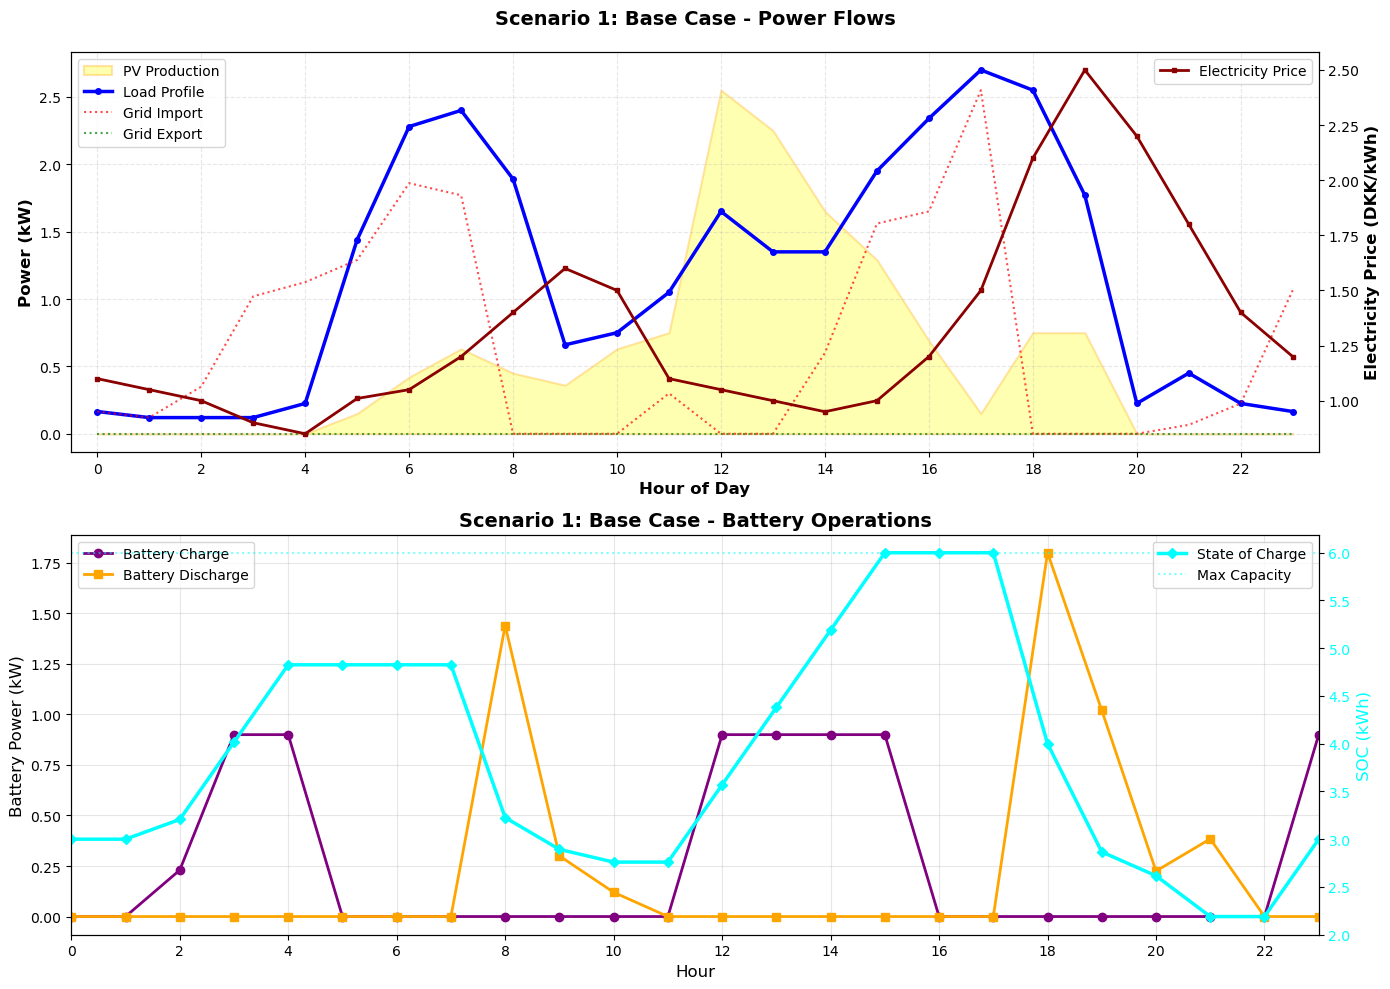

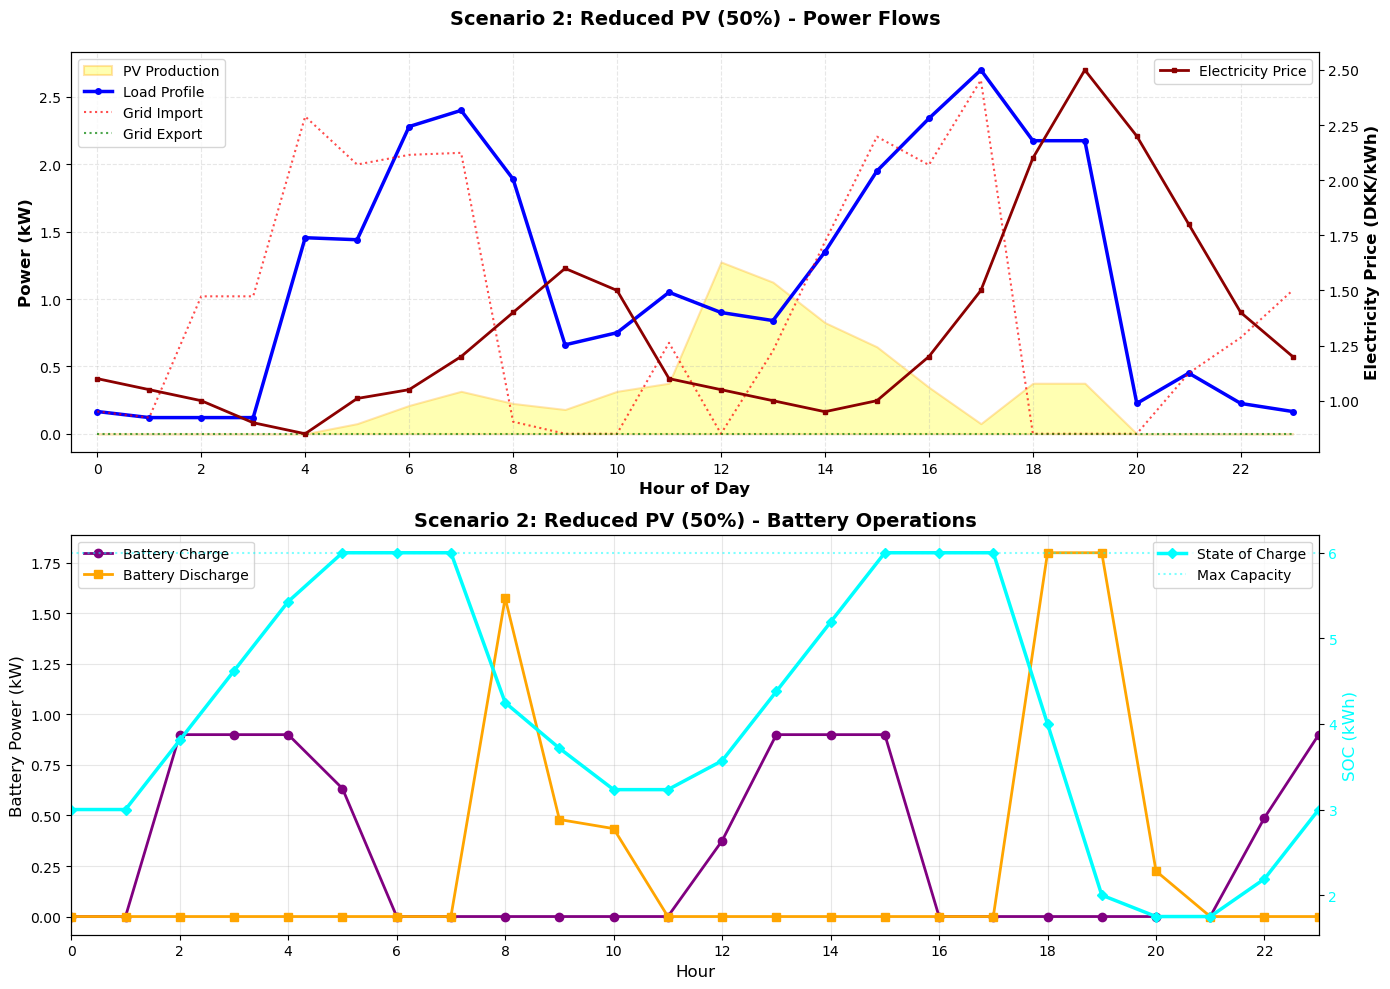

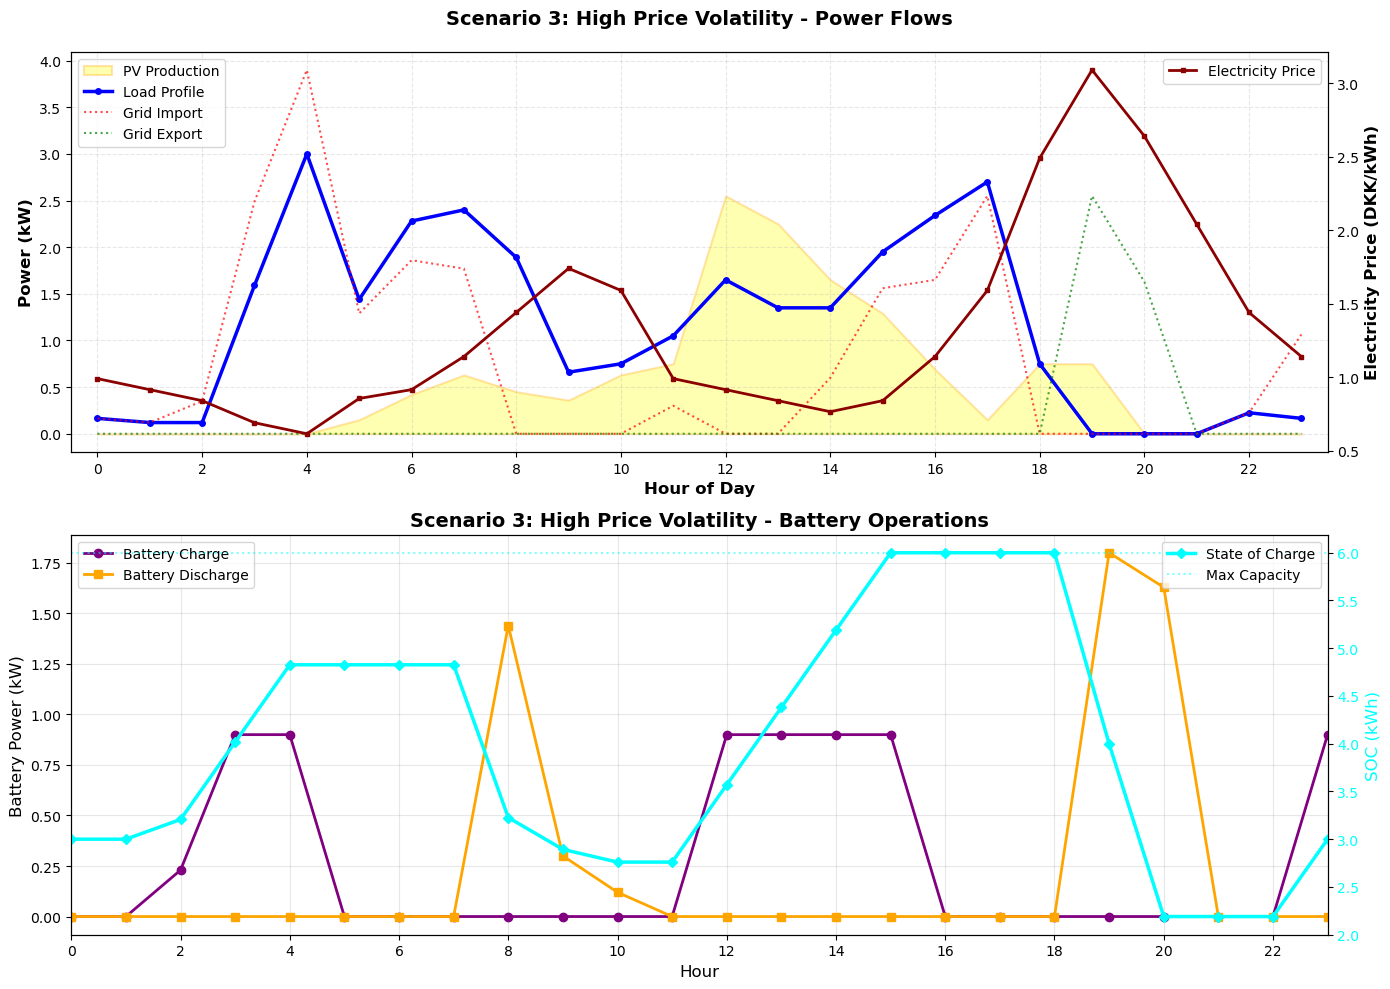

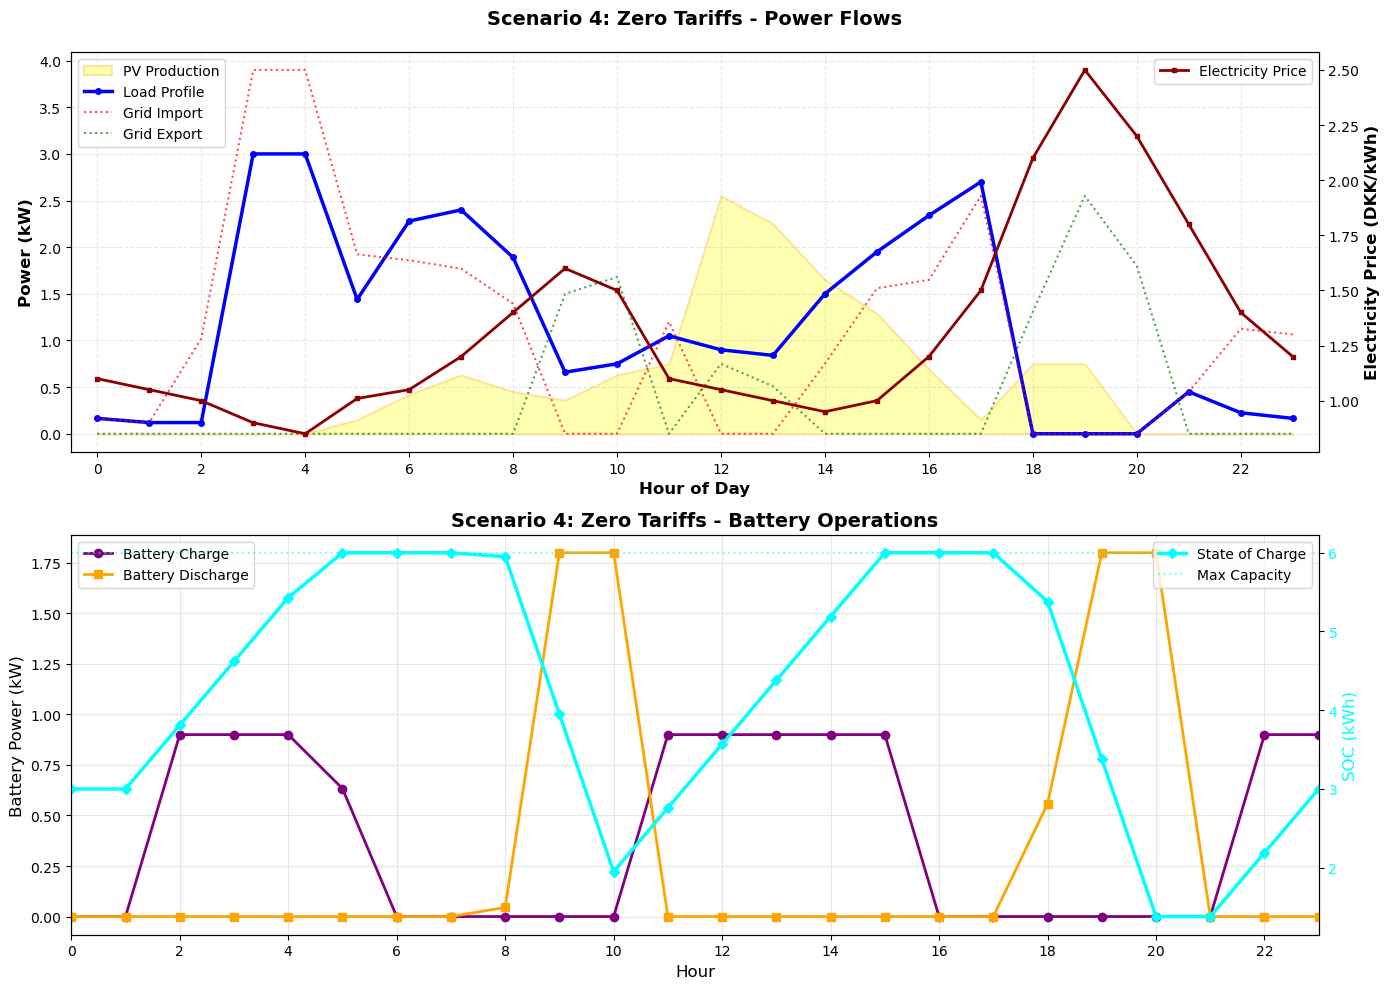

In [66]:
# Plot all 4 scenarios
plot_scenario_with_battery(scenario_1, pv_prod_hourly, electricity_prices, "Scenario 1: Base Case")
plot_scenario_with_battery(scenario_2, pv_reduced, electricity_prices, "Scenario 2: Reduced PV (50%)")
plot_scenario_with_battery(scenario_3, pv_prod_hourly, prices_volatile, "Scenario 3: High Price Volatility")
plot_scenario_with_battery(scenario_4, pv_prod_hourly, electricity_prices, "Scenario 4: Zero Tariffs")

## Alpha Sensitivity Analysis with Battery

**Objective**: Analyze cost-comfort trade-off with battery storage and compare to Part 1.B (no battery)

In [67]:
# Run alpha sensitivity with battery
alpha_values = [round(x * 0.2, 1) for x in range(0, 11)]  # 0.0, 0.2, 0.4, ..., 2.0

print("Running alpha sensitivity analysis WITH battery...")
alpha_results_with_battery = []

for alpha_val in alpha_values:
    result = run_scenario_with_battery(
        f"Alpha_{alpha_val}", pv_prod_hourly, electricity_prices, tau_imp, tau_exp, alpha_val, L_ref,
        max_import, max_export, L_max, Batt_cap, Batt_max_ch_power, Batt_max_dis_power,
        Batt_charging_eff, Batt_discharging_eff, Batt_initial_soc, Batt_final_soc
    )
    if result:
        alpha_results_with_battery.append({
            'alpha': alpha_val,
            'total_cost': result['total_cost'],
            'total_discomfort': result['total_discomfort']
        })

print(f"\n✓ Completed! Tested {len(alpha_results_with_battery)} alpha values.")
print("\nSummary (WITH Battery):")
print(f"{'Alpha':<10} {'Cost (DKK)':<15} {'Discomfort':<15}")
print("-" * 40)
for r in alpha_results_with_battery:
    print(f"{r['alpha']:<10} {r['total_cost']:<15.2f} {r['total_discomfort']:<15.2f}")

Running alpha sensitivity analysis WITH battery...

✓ Completed! Tested 11 alpha values.

Summary (WITH Battery):
Alpha      Cost (DKK)      Discomfort     
----------------------------------------
0.0        19.64           33.21          
0.2        21.27           16.59          
0.4        25.68           2.65           
0.6        25.75           2.52           
0.8        25.75           2.52           
1.0        27.83           0.18           
1.2        28.05           0.00           
1.4        28.05           0.00           
1.6        28.05           0.00           
1.8        28.05           0.00           
2.0        28.05           0.00           


### Plot 5: Alpha Sensitivity (Part 1.C WITH Battery)

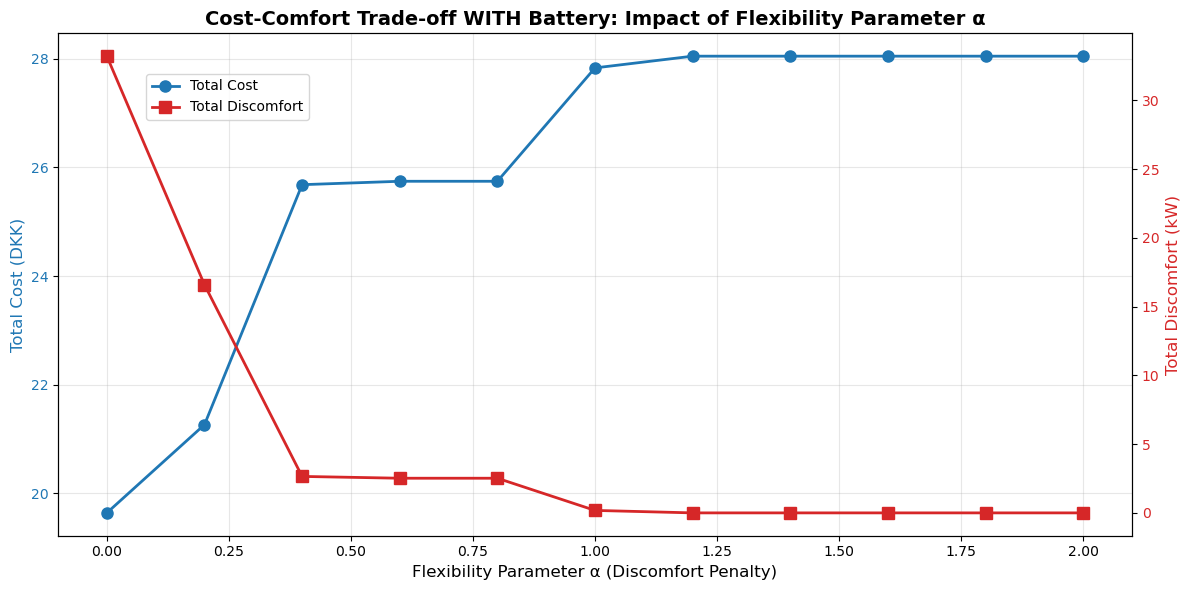


Key Insights (WITH Battery):
- Most flexible (α=0.0): Cost = 19.64 DKK, Discomfort = 33.21 kW
- Mid-range (α=1.0): Cost = 27.83 DKK, Discomfort = 0.18 kW
- Least flexible (α=2.0): Cost = 28.05 DKK, Discomfort = 0.00 kW


In [68]:
# Plot alpha sensitivity WITH battery (same format as Part 1.B)
fig, ax1 = plt.subplots(figsize=(12, 6))

alphas_c = [r['alpha'] for r in alpha_results_with_battery]
costs_c = [r['total_cost'] for r in alpha_results_with_battery]
discomforts_c = [r['total_discomfort'] for r in alpha_results_with_battery]

# Plot cost on left axis
color = 'tab:blue'
ax1.set_xlabel('Flexibility Parameter α (Discomfort Penalty)', fontsize=12)
ax1.set_ylabel('Total Cost (DKK)', color=color, fontsize=12)
ax1.plot(alphas_c, costs_c, marker='o', color=color, linewidth=2, markersize=8, label='Total Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot discomfort on right axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Discomfort (kW)', color=color, fontsize=12)
ax2.plot(alphas_c, discomforts_c, marker='s', color=color, linewidth=2, markersize=8, label='Total Discomfort')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cost-Comfort Trade-off WITH Battery: Impact of Flexibility Parameter α', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=10)
fig.tight_layout()
plt.show()

print("\nKey Insights (WITH Battery):")
print(f"- Most flexible (α={alphas_c[0]}): Cost = {costs_c[0]:.2f} DKK, Discomfort = {discomforts_c[0]:.2f} kW")
print(f"- Mid-range (α={alphas_c[len(alphas_c)//2]}): Cost = {costs_c[len(costs_c)//2]:.2f} DKK, Discomfort = {discomforts_c[len(discomforts_c)//2]:.2f} kW")
print(f"- Least flexible (α={alphas_c[-1]}): Cost = {costs_c[-1]:.2f} DKK, Discomfort = {discomforts_c[-1]:.2f} kW")

### Plot 6: Cost-Comfort Comparison (Part 1.B vs Part 1.C)

**Objective**: Show how battery storage shifts the Pareto frontier of cost-comfort trade-offs

✓ Loaded Part 1.B results: 11 alpha values
  Alpha range: 0.0 to 2.0


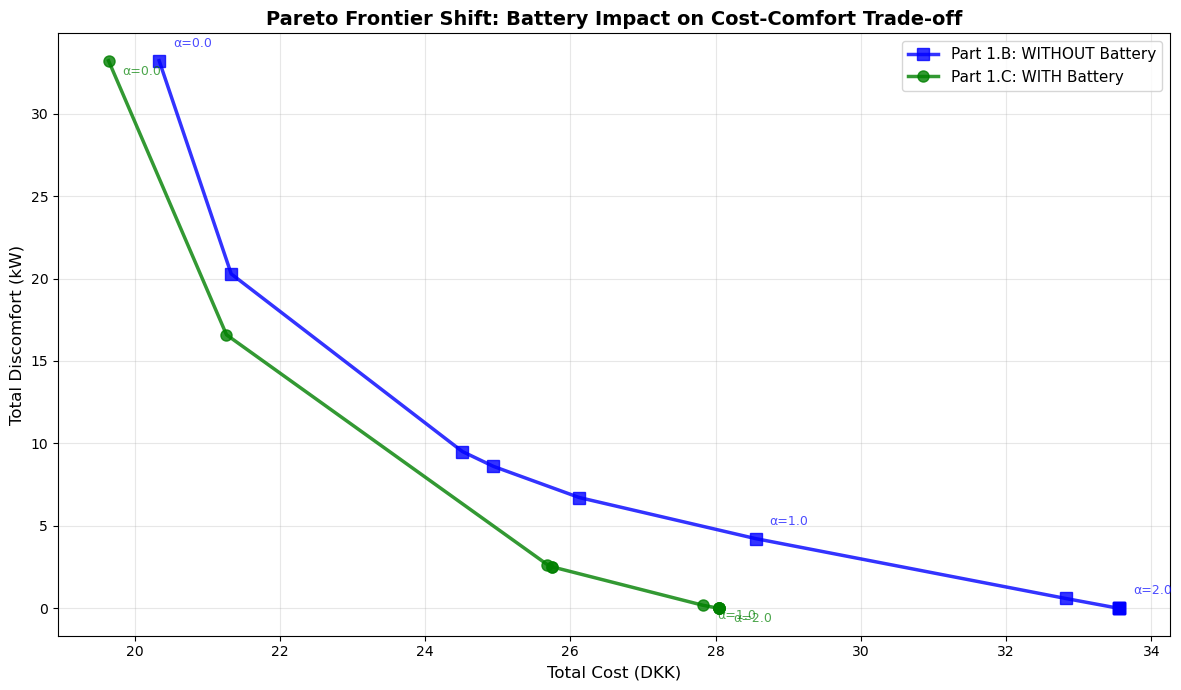


Interpretation:
- Left curve = Better (lower cost for same discomfort)
- Battery shifts curve leftward → cost savings across all flexibility levels
- Horizontal distance = battery value at each flexibility level

Battery Value (Cost Savings):
  α = 0.0: 0.70 DKK (3.4% reduction)
  α = 0.2: 0.07 DKK (0.3% reduction)
  α = 0.4: -1.17 DKK (-4.8% reduction)
  α = 0.6: -0.80 DKK (-3.2% reduction)
  α = 0.8: 0.38 DKK (1.4% reduction)
  α = 1.0: 0.72 DKK (2.5% reduction)
  α = 1.2: 4.77 DKK (14.5% reduction)
  α = 1.4: 5.51 DKK (16.4% reduction)
  α = 1.6: 5.51 DKK (16.4% reduction)
  α = 1.8: 5.51 DKK (16.4% reduction)
  α = 2.0: 5.51 DKK (16.4% reduction)


In [70]:
# Load Part 1.B results for comparison
import pickle

# Import Part 1.B alpha sensitivity results
with open('./results_1b_alpha.pkl', 'rb') as f:
    alpha_results_1b = pickle.load(f)

# Extract Part 1.B data
alphas_b = [r['alpha'] for r in alpha_results_1b]
costs_b = [r['total_cost'] for r in alpha_results_1b]
discomforts_b = [r['total_discomfort'] for r in alpha_results_1b]

print(f"✓ Loaded Part 1.B results: {len(alpha_results_1b)} alpha values")
print(f"  Alpha range: {alphas_b[0]} to {alphas_b[-1]}")

# Plot comparison (FLIPPED AXES: Cost on X, Discomfort on Y)
fig, ax = plt.subplots(figsize=(12, 7))

# Part 1.B (WITHOUT battery)
ax.plot(costs_b, discomforts_b, marker='s', color='blue', linewidth=2.5, markersize=8, 
        label='Part 1.B: WITHOUT Battery', alpha=0.8)

# Part 1.C (WITH battery)
ax.plot(costs_c, discomforts_c, marker='o', color='green', linewidth=2.5, markersize=8, 
        label='Part 1.C: WITH Battery', alpha=0.8)

ax.set_xlabel('Total Cost (DKK)', fontsize=12)
ax.set_ylabel('Total Discomfort (kW)', fontsize=12)
ax.set_title('Pareto Frontier Shift: Battery Impact on Cost-Comfort Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='upper right')

# Add annotations for key points
for i, alpha_val in enumerate(alphas_c):
    if alpha_val in [0.0, 1.0, 2.0]:  # Annotate key alpha values
        ax.annotate(f'α={alpha_val}', 
                   xy=(costs_c[i], discomforts_c[i]),
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=9, alpha=0.7, color='green')

# Add annotations for Part 1.B key points
for i, alpha_val in enumerate(alphas_b):
    if alpha_val in [0.0, 1.0, 2.0]:  # Annotate key alpha values
        ax.annotate(f'α={alpha_val}', 
                   xy=(costs_b[i], discomforts_b[i]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, alpha=0.7, color='blue')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Left curve = Better (lower cost for same discomfort)")
print("- Battery shifts curve leftward → cost savings across all flexibility levels")
print("- Horizontal distance = battery value at each flexibility level")

# Calculate battery value at key alpha values
print("\nBattery Value (Cost Savings):")
for i, alpha_val in enumerate(alphas_c):
    if alpha_val in alphas_b:
        idx_b = alphas_b.index(alpha_val)
        savings = costs_b[idx_b] - costs_c[i]
        savings_pct = (savings / costs_b[idx_b]) * 100
        print(f"  α = {alpha_val}: {savings:.2f} DKK ({savings_pct:.1f}% reduction)")

## Save All Plots

In [ ]:
import os

# Create directory for Part 1.C plots
save_dir = './Plots/Scenarios c/'
os.makedirs(save_dir, exist_ok=True)

print("="*70)
print("SAVING ALL PART 1.C PLOTS")
print("="*70)

# ============================================================================
# 1. Save individual scenario power flow plots (4 scenarios)
# ============================================================================
scenarios_data = [
    (scenario_1, pv_prod_hourly, electricity_prices, "Scenario 1: Base Case", "scenario_1_base_case"),
    (scenario_2, pv_reduced, electricity_prices, "Scenario 2: Reduced PV (50%)", "scenario_2_reduced_pv"),
    (scenario_3, pv_prod_hourly, prices_volatile, "Scenario 3: High Price Volatility", "scenario_3_high_volatility"),
    (scenario_4, pv_prod_hourly, electricity_prices, "Scenario 4: Zero Tariffs", "scenario_4_zero_tariffs")
]

for scenario_data, pv_prod, prices, title, filename in scenarios_data:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    hours = range(24)
    
    # Top plot: Power flows
    ax1.fill_between(hours, pv_prod, alpha=0.3, color='yellow', 
                     label='PV Production', edgecolor='orange', linewidth=1.5)
    ax1.plot(hours, scenario_data['load_profile'], color='blue', linewidth=2.5, 
             label='Load Profile', marker='o', markersize=4)
    ax1.plot(hours, scenario_data['grid_import'], color='red', linewidth=1.5, 
             linestyle=':', label='Grid Import', alpha=0.7)
    ax1.plot(hours, scenario_data['grid_export'], color='green', linewidth=1.5, 
             linestyle=':', label='Grid Export', alpha=0.7)
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{title} - Power Flows', fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.set_xlim(-0.5, 23.5)
    ax1.set_xticks(range(0, 24, 2))
    
    ax1_price = ax1.twinx()
    ax1_price.plot(hours, prices, color='darkred', linewidth=2, 
                  linestyle='-', marker='s', markersize=3, label='Electricity Price')
    ax1_price.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, fontweight='bold')
    ax1_price.legend(loc='upper right', fontsize=10)
    
    # Bottom plot: Battery operations
    ax2.plot(hours, scenario_data['battery_charge'], 'purple', linewidth=2, label='Battery Charge', marker='o')
    ax2.plot(hours, scenario_data['battery_discharge'], 'orange', linewidth=2, label='Battery Discharge', marker='s')
    ax2.set_xlabel('Hour', fontsize=12)
    ax2.set_ylabel('Battery Power (kW)', fontsize=12)
    ax2.set_title(f'{title} - Battery Operations', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=10)
    ax2.set_xlim(0, 23)
    ax2.set_xticks(range(0, 24, 2))
    
    ax2_soc = ax2.twinx()
    ax2_soc.plot(hours, scenario_data['soc'], 'cyan', linewidth=2.5, label='State of Charge', marker='D', markersize=5)
    ax2_soc.set_ylabel('SOC (kWh)', fontsize=12, color='cyan')
    ax2_soc.tick_params(axis='y', labelcolor='cyan')
    ax2_soc.axhline(y=Batt_cap, color='cyan', linestyle=':', alpha=0.5, label='Max Capacity')
    ax2_soc.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}{filename}.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved: {filename}.png")

# ============================================================================
# 2. Save alpha sensitivity plot (Part 1.C with battery)
# ============================================================================
fig, ax1 = plt.subplots(figsize=(12, 6))

alphas_c = [r['alpha'] for r in alpha_results_with_battery]
costs_c = [r['total_cost'] for r in alpha_results_with_battery]
discomforts_c = [r['total_discomfort'] for r in alpha_results_with_battery]

color = 'tab:blue'
ax1.set_xlabel('Flexibility Parameter α (Discomfort Penalty)', fontsize=12)
ax1.set_ylabel('Total Cost (DKK)', color=color, fontsize=12)
ax1.plot(alphas_c, costs_c, marker='o', color=color, linewidth=2, markersize=8, label='Total Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Discomfort (kW)', color=color, fontsize=12)
ax2.plot(alphas_c, discomforts_c, marker='s', color=color, linewidth=2, markersize=8, label='Total Discomfort')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cost-Comfort Trade-off WITH Battery: Impact of Flexibility Parameter α', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=10)
fig.tight_layout()
plt.savefig(f'{save_dir}alpha_sensitivity_with_battery.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"✓ Saved: alpha_sensitivity_with_battery.png")

# ============================================================================
# 3. Save Pareto frontier comparison (Part 1.B vs Part 1.C)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Part 1.B (WITHOUT battery)
ax.plot(costs_b, discomforts_b, marker='s', color='blue', linewidth=2.5, markersize=8, 
        label='Part 1.B: WITHOUT Battery', alpha=0.8)

# Part 1.C (WITH battery)
ax.plot(costs_c, discomforts_c, marker='o', color='green', linewidth=2.5, markersize=8, 
        label='Part 1.C: WITH Battery', alpha=0.8)

ax.set_xlabel('Total Cost (DKK)', fontsize=12)
ax.set_ylabel('Total Discomfort (kW)', fontsize=12)
ax.set_title('Pareto Frontier Shift: Battery Impact on Cost-Comfort Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='upper right')

# Add annotations for key points
for i, alpha_val in enumerate(alphas_c):
    if alpha_val in [0.0, 1.0, 2.0]:
        ax.annotate(f'α={alpha_val}', 
                   xy=(costs_c[i], discomforts_c[i]),
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=9, alpha=0.7, color='green')

for i, alpha_val in enumerate(alphas_b):
    if alpha_val in [0.0, 1.0, 2.0]:
        ax.annotate(f'α={alpha_val}', 
                   xy=(costs_b[i], discomforts_b[i]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, alpha=0.7, color='blue')

plt.tight_layout()
plt.savefig(f'{save_dir}pareto_comparison_battery_impact.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"✓ Saved: pareto_comparison_battery_impact.png")

# ============================================================================
# Summary
# ============================================================================
print("="*70)
print(f"All plots saved successfully to: {save_dir}")
print(f"Total files saved: 7")
print("  - 4 individual scenario plots (power flows + battery operations)")
print("  - 1 alpha sensitivity plot (with battery)")
print("  - 1 Pareto frontier comparison (with vs without battery)")
print("="*70)